# **\[PyG\]** lesson6: GCN

신록예찬  
2023-08-25

# GCN

# ref

Kipf and Welling (2016): <https://arxiv.org/abs/1609.02907>

In [1]:
import torch
import torch_geometric

# layer-wise progagation rule

Kipf and Welling (2016) use following layer-wise propagation rule:

$$H^{(l+1)} = \sigma\big(\tilde{D}^{-1/2}\tilde{A}\tilde{D}^{-1/2}H^{(l)}W^{(l)}\big).$$

Check followings:

-   In Kipf and Welling (2016) research, they suppose ${\cal G}$ as
    undirected graph.
-   $\tilde{A}=A+I_{N}$.
-   $\tilde{D}_{ii}=\sum_{j}\tilde{A}_{ij}$.
-   $W^{(l)}$ is a trainable weight matrix in $l$-th layer.
-   $H^{(l)}$ is output of $l$-th layer; $H^{(0)}=X$.

## 예제

`-` data

In [2]:
x = torch.tensor([[20],
                  [21],
                  [19],
                  [1],
                  [2],
                  [1]], dtype=torch.float)

edge_index = torch.tensor([[0, 1, 2, 0, 1, 2, 3, 4, 3, 5, 4, 5],
                           [1, 0, 0, 2, 2, 1, 4, 3, 5, 3, 5, 4]], dtype=torch.long)

y = torch.tensor([1,1,1,0,0,0], dtype=torch.int64)
data = torch_geometric.data.Data(x=x, edge_index=edge_index, y=y) 
#data.train_mask = torch.tensor([True,False,True,True,False,True])
#data.test_mask = torch.tensor([False,True,False,False,True,False])
data

`-` GCNConv

In [4]:
gconv = torch_geometric.nn.GCNConv(1,4)
gconv

In [10]:
gconv(data.x, data.edge_index)

In [13]:
list(gconv.parameters())

In [14]:
_,W = list(gconv.parameters())
W

In [15]:
A = torch.tensor([[0., 1., 1., 0., 0., 0.],
                  [1., 0., 1., 0., 0., 0.],
                  [1., 1., 0., 0., 0., 0.],
                  [0., 0., 0., 0., 1., 1.],
                  [0., 0., 0., 1., 0., 1.],
                  [0., 0., 0., 1., 1., 0.]])
Atilde = A+torch.eye(6) # A + I
Atilde

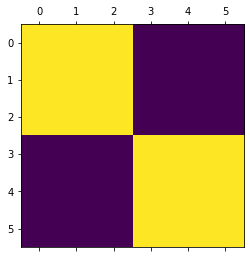

In [18]:
import matplotlib.pyplot as plt
plt.matshow(Atilde)

`-` `torch_geometric.nn.GCNConv()` 직접 구현

$H^{(l+1)} = \sigma\big(\tilde{D}^{-1/2}\tilde{A}\tilde{D}^{-1/2}H^{(l)}W^{(l)}\big)$
에서 $\tilde{D}^{-1/2}\tilde{A}\tilde{D}^{-1/2}H^{(l)}W^{(l)}$ 이 부분을
직접 계산해보자.

In [26]:
Atilde.shape, data.x.shape, W.shape

In [23]:
Atilde@data.x

-   $\tilde{D}_{ii}=\sum_{j}\tilde{A}_{ij}$. : 각 노드의 차수를 나타내는
    대각행렬

In [30]:
# step1: adjacency matrix + self loop
Atilde 

In [39]:
# step2: calculate D tilde
degree_vector = torch.sum(Atilde, axis=1)  # 각 노드의 차수 계산
Dtilde = np.diag(degree_vector)  # 대각 행렬 D tilde
Dtilde

In [47]:
# step3: calculate D tilde inverse square root
Dtilde_sqrt_inv = np.linalg.inv(np.sqrt(Dtilde))
Dtilde_sqrt_inv

In [58]:
# step4: calculate normalized adjacency matrix
normalized_adjacency_matrix = (Dtilde_sqrt_inv@Atilde.numpy())@Dtilde_sqrt_inv
normalized_adjacency_matrix

In [68]:
# step5
normalized_adjacency_matrix@data.x.numpy()@W.detach().numpy().T

In [19]:
Atilde@data.x@W.T/3, gconv(data.x,data.edge_index) # 똑같다!

`-` 즉 아래의 수식에서

$$H^{(l+1)} = \sigma\big(\tilde{D}^{-1/2}\tilde{A}\tilde{D}^{-1/2}H^{(l)}W^{(l)}\big).$$

$\tilde{D}^{-1/2}\tilde{A}\tilde{D}^{-1/2}H^{(l)}W^{(l)}$를 계산하는
Layer가 `torch_geometric.nn.GCNConv()` 으로 구현되어있음.

# Spectral graph convolutions (Section 2.1-2)

`-` In this chapter, Kipf and Welling (2016) argues why the calculation

$$H^{(l+1)} = \sigma\big(\tilde{D}^{-1/2}\tilde{A}\tilde{D}^{-1/2}H^{(l)}W^{(l)}\big).$$

can be considered as graph convolution.

`-` The properties of convolution operator $\star$ in classical spectral
analysis are as follows (3):

$$g_{\theta} \star x = Ug_{\theta}U^\top x$$

where $g_{\theta}=\text{diag}(\theta)$ and $U$ is eigenvector matrix of
$L=I-D^{-1/2}AD^{-1/2}$.

`-` Now let’s examine equation (7):

$$g_{\theta}\star x \approx \theta \big(I+D^{-1/2}AD^{-1/2}\big)x. \cdots (7)$$

By expressing equation (7) matrix form, we get equation (8):

$$Z = \tilde{D}^{-1/2}\tilde{A}\tilde{D}^{-1/2}X \Theta. \cdots (8)$$

This can be transfromed to

$$H^{(l+1)} = \sigma\big(Z\big)= \sigma\big(\tilde{D}^{-1/2}\tilde{A}\tilde{D}^{-1/2}H^{(l)}W^{(l)}\big).$$

where we interpret $H^{(l)}$ as $X$ and $W^{(l)}$ as $\Theta$.

Kipf, Thomas N, and Max Welling. 2016. “Semi-Supervised Classification
with Graph Convolutional Networks.” *arXiv Preprint arXiv:1609.02907*.